In [191]:
import io
import os
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [192]:
# !pip install openpyxl

In [193]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2022-12-17 23:34:29--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.198.217.117, 2600:141b:7000:58a::317f, 2600:141b:7000:59d::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.198.217.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: 'kagglecatsanddogs_5340.zip'

kagglecatsanddogs_5 100%[===================>] 786.67M  20.3MB/s    in 49s     

2022-12-17 23:35:18 (16.1 MB/s) - 'kagglecatsanddogs_5340.zip' saved [824887076/824887076]



In [195]:
!unzip kagglecatsanddogs_5340.zip

Archive:  kagglecatsanddogs_5340.zip
   creating: PetImages/Cat/
  inflating: PetImages/Cat/0.jpg     
  inflating: PetImages/Cat/1.jpg     
  inflating: PetImages/Cat/10.jpg    
  inflating: PetImages/Cat/100.jpg   
  inflating: PetImages/Cat/1000.jpg  
  inflating: PetImages/Cat/10000.jpg  
  inflating: PetImages/Cat/10001.jpg  
  inflating: PetImages/Cat/10002.jpg  
  inflating: PetImages/Cat/10003.jpg  
  inflating: PetImages/Cat/10004.jpg  
  inflating: PetImages/Cat/10005.jpg  
  inflating: PetImages/Cat/10006.jpg  
  inflating: PetImages/Cat/10007.jpg  
  inflating: PetImages/Cat/10008.jpg  
  inflating: PetImages/Cat/10009.jpg  
  inflating: PetImages/Cat/1001.jpg  
  inflating: PetImages/Cat/10010.jpg  
  inflating: PetImages/Cat/10011.jpg  
  inflating: PetImages/Cat/10012.jpg  
  inflating: PetImages/Cat/10013.jpg  
  inflating: PetImages/Cat/10014.jpg  
  inflating: PetImages/Cat/10015.jpg  
  inflating: PetImages/Cat/10016.jpg  
  inflating: PetImages/Cat/10017.jpg  
  inf

In [197]:
data_pet = "PetImages"
print(data_pet_dir)

PetImages


In [198]:
data = tf.keras.preprocessing.image_dataset_from_directory(data_pet)

Found 25000 files belonging to 2 classes.


In [199]:
!ls "PetImages"

Cat Dog


In [200]:
for image_batch, labels_batch in data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


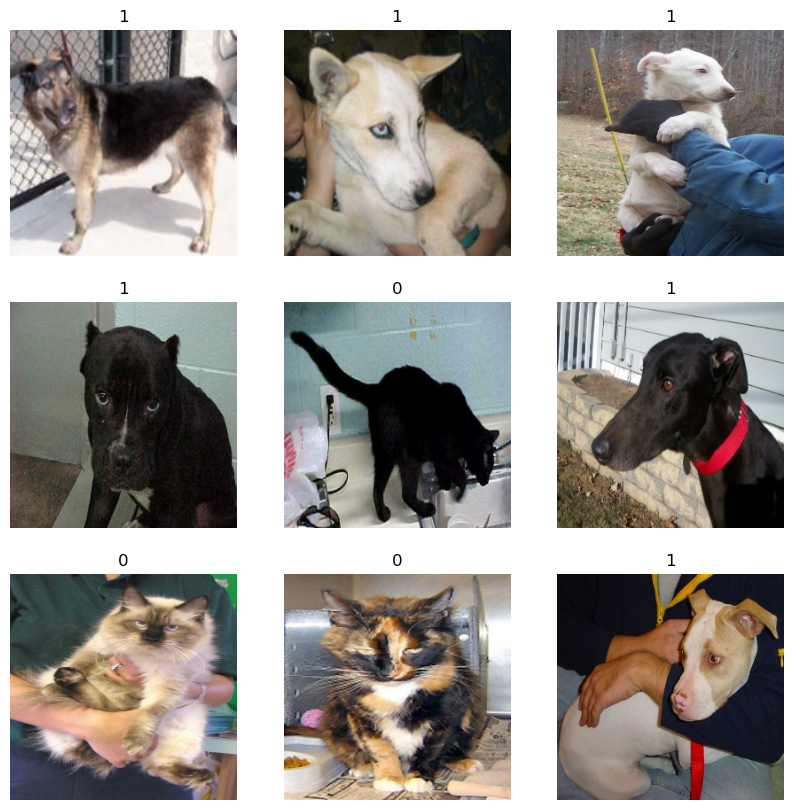

In [201]:
plt.figure(figsize=(10,10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [202]:
batch_size = 128
img_height = 256
img_width = 256

In [203]:
data_skip = 0
for name in ("Cat","Dog"):
    path = os.path.join(data_pet,name)
    for file_name in os.listdir(path):
        file_path = os.path.join(path,file_name)
        try:
            file_obj = open(file_path,"rb")
            file_jfif = tf.compat.as_bytes("JFIF") in file_obj.peek(10)
        finally:
            file_obj.close()
        if not file_jfif:
            data_skip += 1
            os.remove(file_path)
print("Deleted %d images" % data_skip)

Deleted 1590 images


In [204]:
augment = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

In [205]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_pet,
    validation_split = 0.3,
    subset = "training",
    seed = 234,
    image_size = (img_height, img_width),
    batch_size = batch_size)
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_pet,
    validation_split = 0.3,
    subset = "validation",
    seed = 234,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


In [206]:
c_name =train_data.class_names
c_name = val_data.class_names

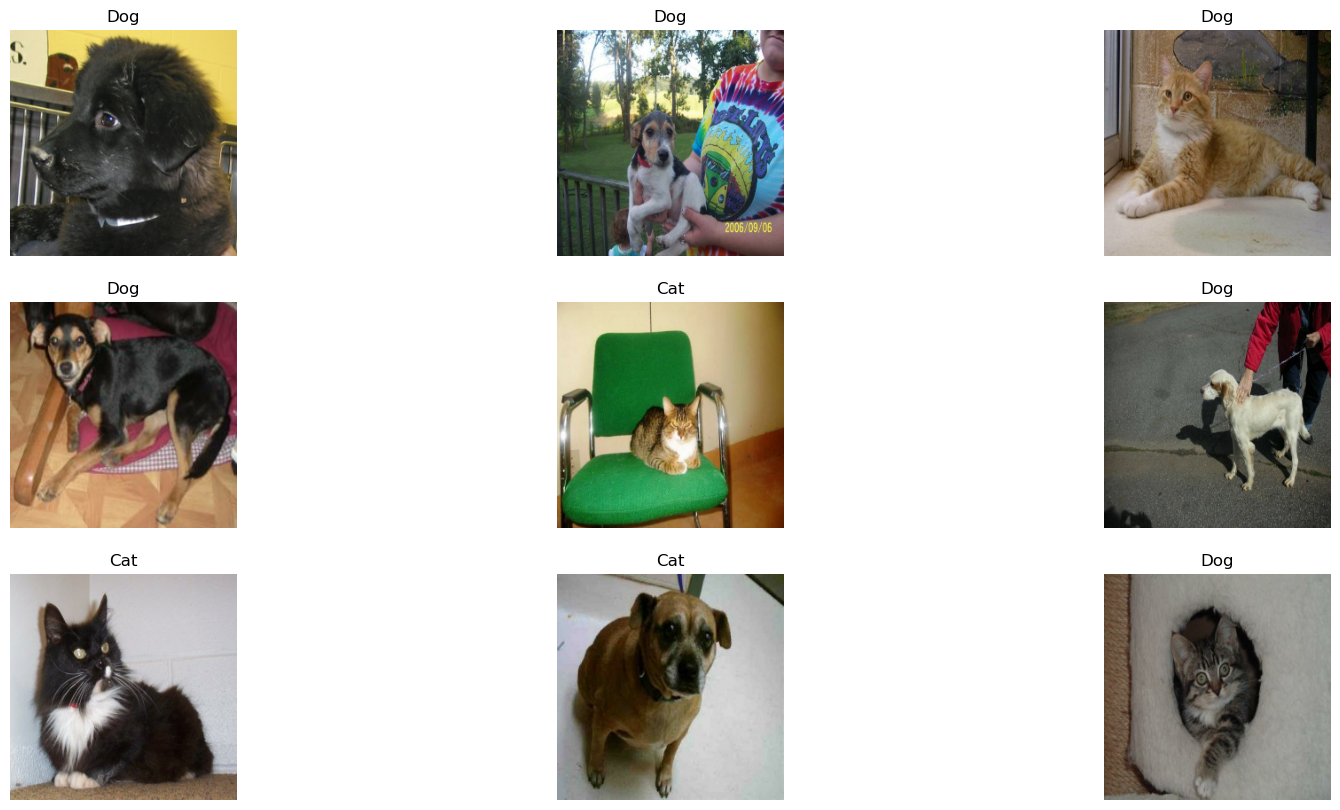

In [207]:
plt.figure(figsize=(20,10))
for images, label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(c_name[labels[i]])
        plt.axis("off")

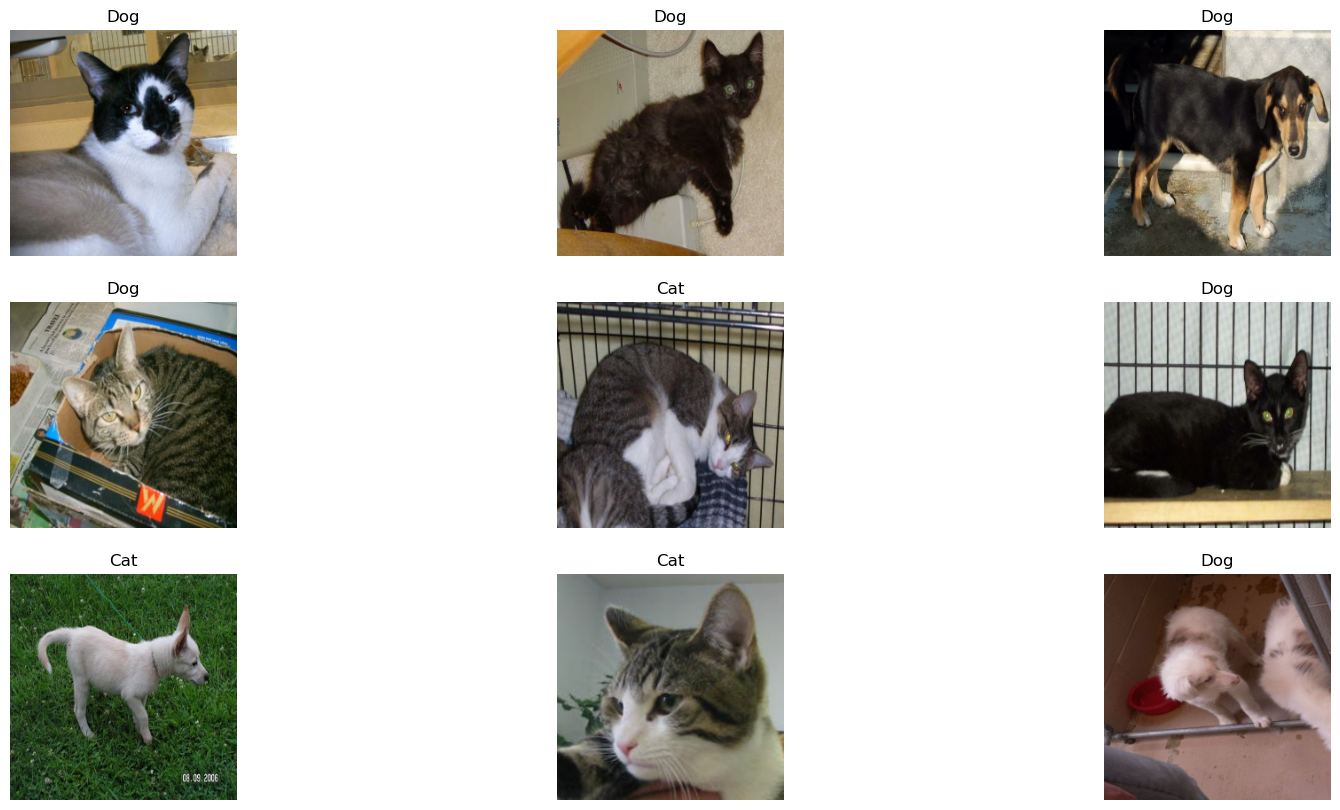

In [208]:
plt.figure(figsize=(20,10))
for images, label in val_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(c_name[labels[i]])
        plt.axis("off")

In [215]:
first_model = tf.keras.models.Sequential([tf.keras.layers.Rescaling(1./255),
                                        tf.keras.layers.Conv2D(32,(3,3), activation = 'relu',input_shape = (256,256,3)),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.MaxPooling2D(2,2),
                                        tf.keras.layers.Dropout(0,25),
                                          
                                        tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(2,2),
                                        tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(2,2),
                                        tf.keras.layers.Conv2D(128,(3,3),activation = 'relu'),
                                        tf.keras.layers.MaxPooling2D(2,2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(512, activation = 'relu'),
                                        tf.keras.layers.Dense(2, activation = 'softmax')])

In [227]:
first_model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [224]:
AUTOTUNE = tf.data.AUTOTUNE

In [225]:
train_data = train_data.cache().prefetch(buffer_size = AUTOTUNE)

In [226]:
val_data = val_data.cache().prefetch(buffer_size = AUTOTUNE)

In [229]:
byte_flag = 'JPEG'

In [234]:
first_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_61 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_18 (Bat  (None, 254, 254, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_62 (Conv2D)          (None, 125, 125, 64)    

2022-12-18 00:13:49.359130: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 max_pooling2d_63 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 25088)             0         
                                                                 
 dense_28 (Dense)            (None, 512)               12845568  
                                                                 
 dense_29 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 13,087,554
Trainable params: 13,087,490
Non-trainable params: 64
_________________________________________________________________


In [230]:
history = first_model.fit(train_data,validation_data = val_data, epochs = 50)

Epoch 1/50
  3/129 [..............................] - ETA: 27:45 - loss: 0.8453 - accuracy: 0.6016

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


KeyboardInterrupt: 